In [22]:
import pandas as pd
import numpy as np

import tensorflow as tf
import transformers #huggingface transformers library

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import sklearn
from sklearn.metrics import confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt

In [23]:
# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


In [24]:
df = pd.read_csv("../data/train/text_dataset_50.csv")
df = df.dropna(subset=['text'])
df_50 = df.head(10000)

In [25]:
print(f"The dataset contains { df_50.interest.nunique() } unique categories")

The dataset contains 3 unique categories


In [26]:
#label encoding the categories. After this each category would be mapped to an integer.
encoder = LabelEncoder()
df_50['interestEncoded'] = encoder.fit_transform(df_50['interest'])

C:\Users\Izzham Burhan\AppData\Local\Temp\ipykernel_164\2494960869.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_50['interestEncoded'] = encoder.fit_transform(df_50['interest'])


In [27]:
# change to lower case
df_50['text'] = df_50['text'].apply(lambda text: str(text).lower())

C:\Users\Izzham Burhan\AppData\Local\Temp\ipykernel_164\3953981823.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_50['text'] = df_50['text'].apply(lambda text: str(text).lower())


In [28]:
#calculating the length of headlines and descriptions
df_50['text_len'] = df_50['text'].apply(lambda x: len(str(x).split()))
df_50

C:\Users\Izzham Burhan\AppData\Local\Temp\ipykernel_164\3223165318.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_50['text_len'] = df_50['text'].apply(lambda x: len(str(x).split()))


,text,location,interest,interestEncoded,text_len
0,attempt hari tu act like smart deep tech entre...,Unknown,Technology,2,28
1,mosti cradle ni clueless whats going tech tal...,Unknown,Technology,2,28
2,hightech export country 942b hong kong 431b g...,Unknown,Technology,2,30
3,tbh many tech talent dont actually need focus...,Unknown,Technology,2,31
4,make 180000 tech consultant london grew extrem...,Unknown,Technology,2,25
...,...,...,...,...,...
9995,album dangerous woman apple music 41 philippin...,Unknown,Entertainment,0,36
9996,1 british rock band coldplay confirmed coming ...,Unknown,Entertainment,0,23
9997,aespaofficial 3rd mini album world apple music...,Unknown,Entertainment,0,43
9998,shoot across sky coldplay coming coldplay mus...,Unknown,Entertainment,0,13


In [29]:
df_50.describe()

,interestEncoded,text_len
count,10000.000000,10000.000000
mean,1.258700,19.518600
std,0.755269,7.808467
min,0.000000,1.000000
25%,1.000000,14.000000
50%,1.000000,20.000000
75%,2.000000,25.000000
max,2.000000,74.000000


C:\Users\Izzham Burhan\AppData\Local\Temp\ipykernel_164\3854569899.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_50['text_len'])


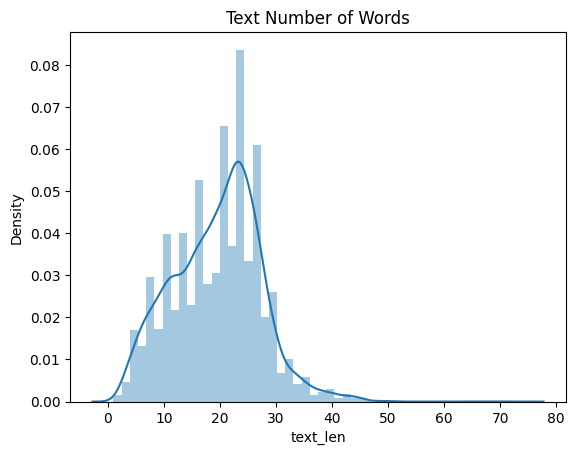

In [30]:
sns.distplot(df_50['text_len'])
plt.title('Text Number of Words')
plt.show()

C:\Users\Izzham Burhan\AppData\Local\Temp\ipykernel_164\808589902.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_50['interestEncoded'])


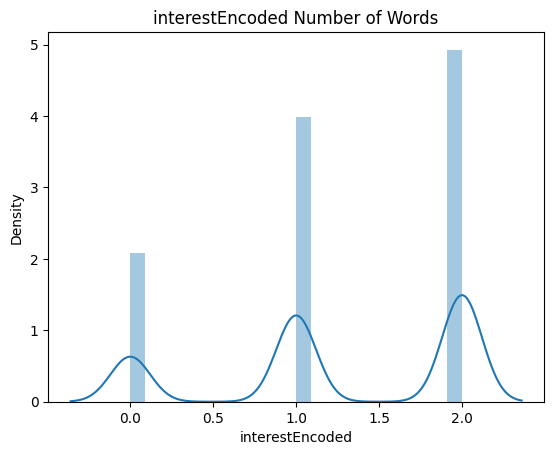

In [31]:
sns.distplot(df_50['interestEncoded'])
plt.title('interestEncoded Number of Words')
plt.show()

In [32]:
def regular_encode(texts, tokenizer, maxlen=512):
    enc_di = tokenizer.batch_encode_plus(
        texts, 
        return_attention_masks=False, 
        return_token_type_ids=False,
        pad_to_max_length=True,
        max_length=maxlen
    )
    
    return np.array(enc_di['input_ids'])

In [33]:
#bert large uncased pretrained tokenizer
tokenizer = transformers.BertTokenizer.from_pretrained('bert-large-uncased')

In [36]:
X_train,X_test ,y_train,y_test = train_test_split(df_50['text'], df_50['interestEncoded'], random_state = 2020, test_size = 0.2)

In [37]:
#tokenizing the news descriptions and converting the categories into one hot vectors using tf.keras.utils.to_categorical
Xtrain_encoded = regular_encode(X_train.astype('str'), tokenizer, maxlen=80)
ytrain_encoded = tf.keras.utils.to_categorical(y_train, num_classes=40,dtype = 'int32')
Xtest_encoded = regular_encode(X_test.astype('str'), tokenizer, maxlen=80)
ytest_encoded = tf.keras.utils.to_categorical(y_test, num_classes=40,dtype = 'int32')

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
c:\Users\Izzham Burhan\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\tokenization_utils_base.py:2418: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Keyword arguments {'return_attention_masks': False} not re

In [38]:
def build_model(transformer, loss='categorical_crossentropy', max_len=512):
    input_word_ids = tf.keras.layers.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    sequence_output = transformer(input_word_ids)[0]
    cls_token = sequence_output[:, 0, :]
    #adding dropout layer
    x = tf.keras.layers.Dropout(0.3)(cls_token)
    #using a dense layer of 40 neurons as the number of unique categories is 40. 
    out = tf.keras.layers.Dense(40, activation='softmax')(x)
    model = tf.keras.Model(inputs=input_word_ids, outputs=out)
    #using categorical crossentropy as the loss as it is a multi-class classification problem
    model.compile(tf.keras.optimizers.Adam(lr=3e-5), loss=loss, metrics=['accuracy'])
    return model

In [39]:
#building the model on tpu
with strategy.scope():
    transformer_layer = transformers.TFAutoModel.from_pretrained('bert-large-uncased')
    model = build_model(transformer_layer, max_len=80)
model.summary()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_word_ids (InputLayer  [(None, 80)]              0         
 )                                                               
                                                                 
 tf_bert_model_1 (TFBertMod  TFBaseModelOutputWithPo   335141888 
 el)                         olingAndCrossAttentions             
                             (last_hidden_state=(Non             
                             e, 80, 1024),                       
                              pooler_output=(None, 1             
                             024),                               
                              past_key_values=None,              
                             hidden_states=None, att             
                             entions=None, cross_att             
                             entions=None)                 

In [40]:
#creating the training and testing dataset.
BATCH_SIZE = 32*strategy.num_replicas_in_sync
AUTO = tf.data.experimental.AUTOTUNE 
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((Xtrain_encoded, ytrain_encoded))
    .repeat()
    .shuffle(2048)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)
test_dataset = (
    tf.data.Dataset
    .from_tensor_slices(Xtest_encoded)
    .batch(BATCH_SIZE)
)

In [41]:
#training for 10 epochs
n_steps = Xtrain_encoded.shape[0] // BATCH_SIZE
train_history = model.fit(
    train_dataset,
    steps_per_epoch=n_steps,
    epochs=10
)

Epoch 1/10


 32/250 [==>...........................] - ETA: 14:31:51 - loss: 2.3607 - accuracy: 0.3594

In [ ]:
#making predictions
preds = model.predict(test_dataset,verbose = 1)
#converting the one hot vector output to a linear numpy array.
pred_classes = np.argmax(preds, axis = 1)

NameError: name 'model' is not defined

In [ ]:
#extracting the classes from the label encoder
encoded_classes = encoder.classes_
#mapping the encoded output to actual categories
predicted_category = [encoded_classes[x] for x in pred_classes]
true_category = [encoded_classes[x] for x in y_test]

In [ ]:
result_df = pd.DataFrame({'text':X_test,'true_category':true_category, 'predicted_category':predicted_category})
result_df.head()

In [ ]:
print(f"Accuracy is {sklearn.metrics.accuracy_score(result_df['true_category'], result_df['predicted_category'])}")